In [41]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, Flatten, MaxPooling1D, Dropout, concatenate
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
import itertools

In [42]:
#doses pulled from Data Analysis/CLOCK_DATA/ACLK Graph to match LPM0,2,4 on first 11 trials - maybe automate this later
doses = np.array([ 0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 , 32.64, 38.08,
       48.96, 54.4,  0.  ,  5.44, 10.88, 16.32, 21.76, 27.2 ,
       32.64, 38.08, 48.96, 54.4,  0.  ,  5.44, 10.88,
       16.32, 21.76, 27.2 , 32.64, 38.08, 48.96, 54.4])
classes = ["0-16.32", "16.32-43.52", "43.52+"]

In [43]:
def rolling_window(a, window):
    pad = np.ones(len(a.shape), dtype=np.int32)
    pad[-1] = window-1
    pad = list(zip(pad, np.zeros(len(a.shape), dtype=np.int32)))
    a = np.pad(a, pad,mode='reflect')
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [44]:
test = pd.read_csv(f"/Users/trevorpeyton/Downloads/Channel1/LPM2_Trial11.csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()

In [50]:
def calc_jitter(data, target):
    delta = np.array([y-x for x, y in zip(data, data[1:])])
    delta_global = delta - delta.mean()
    delta_local = np.array([y-x for x, y in zip(delta, delta[1:])])
    delta_global = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta_global, delta)))))
    delta_local = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta_local, delta)))))
    delta = np.array(list(itertools.chain(*(itertools.repeat(elem, n) for elem, n in zip(delta, delta)))))
    #return delta, delta_global, delta_local
    return (np.pad(delta, (target - len(delta), 0), 'constant'),
         np.pad(delta_global, (target - len(delta_global), 0), 'constant'),
         np.pad(delta_local, (target - len(delta_local), 0), 'constant'))
    
#testingn jitter measurements
# print(f"trail, rising time steps, falling time steps, rising avg diff, falling avg diff, rising local diff, falling local diff")
# for x in ["0", "2", "4-1"]:
#     for i in range(11):
#         test = pd.read_csv(f"/Users/trevorpeyton/Downloads/Channel1/LPM{x}_Trial{i}.csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy()
        
#         rise_fall_times = []
#         current, prev = test[0], test[0]
#         first_rise = False #keep track of first rise so we don't mix up rising/falling data
#         for n, val in enumerate(test):
#             prev, current = current, val
#             rising = prev > 1.5 and current < 1.5
#             falling = prev < 1.5 and current > 1.5
#             if rising or falling:
#                 rise_fall_times.append(n)
        
#         cycles_first = rise_fall_times[::2] #first edge (rising/falling)
#         cycles_second = rise_fall_times[1::2] #second edge (rising/falling)
        
#         rising_delta, rising_delta_global, rising_delta_local = calc_jitter(cycles_first, test.shape[0])
#         falling_delta, falling_delta_global, falling_delta_local = calc_jitter(cycles_second, test.shape[0])
        
        #print(f"LPM{x}_Trail{i} {rising_delta.mean()} {falling_delta.mean()} {rising_delta_global.mean()} {falling_delta_global.mean()} {rising_delta_local.mean()} {falling_delta_local.mean()}")
    #print()

In [53]:
#load data
trial_path = "/Users/trevorpeyton/Downloads/"
trial_numbers = [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
channels = ["Channel1"]
modes = ["LPM0"]#, "LPM2"]#, "LPM4-2"]
trial_labels = [(f"{channel}/{mode}_Trial{number}", mode) for mode in modes for number in trial_numbers for channel in channels] #modified to pass along mode
trials = [(pd.read_csv(trial_path + label + ".csv", usecols=[3, 4], names=["time", "v"]).v.to_numpy(), mode) for label, mode in trial_labels] #(data, mode)

trial_slide_width = 400
test_percent = .3
val_percent = .3 #percent of test set to be reserved for validation


#temp_df = {"raw": [], "rise_delta": [], "rise_global": [], "rise_local": [], "fall_delta": [], "fall_global": [], "fall_local": [], "class": [], "mode": []}
temp_df = {"raw": [], "class": [], "mode": []}

for i, (trial, mode) in enumerate(trials):
    #jitter measurements
    # rise_fall_times = []
    # current, prev = trial[0], trial[0]
    # first_rise = False #keep track of first rise so we don't mix up rising/falling data
    # for n, val in enumerate(trial):
    #     prev, current = current, val
    #     rising = prev > 1.5 and current < 1.5
    #     falling = prev < 1.5 and current > 1.5
    #     if rising or falling:
    #         rise_fall_times.append(n)
    
    # cycles_first = rise_fall_times[::2] #first edge (rising/falling)
    # cycles_second = rise_fall_times[1::2] #second edge (rising/falling)
    
    # first_delta, first_delta_global, first_delta_local = calc_jitter(cycles_first, trial.shape[0])
    # second_delta, second_delta_global, second_delta_local = calc_jitter(cycles_second, trial.shape[0])
    
    #normalize all values using z-score
    trial_copy = np.zeros(trial.shape)
    trial_copy[trial > 2] = (trial[trial > 2] - trial[trial > 2].mean()) / trial[trial > 2].std()
    trial_copy[trial < 2] = (trial[trial < 2] - trial[trial < 2].mean()) / trial[trial < 2].std()
    
    #if using jitter data
    #trial_copy = np.stack((trial_copy, first_delta, first_delta_global, first_delta_local, second_delta, second_delta_global, second_delta_local))
    #for win in np.lib.stride_tricks.sliding_window_view(trial_copy, (trial_copy.shape[0], trial_slide_width))[:, ::trial_slide_width].squeeze(0):
    #if not using jitter data, pass tiral_copy directly
    for win in np.lib.stride_tricks.sliding_window_view(trial_copy, trial_slide_width)[::trial_slide_width]:
        temp_df["raw"].append(win)
        temp_df["mode"].append(mode)
        temp_df["class"].append(doses[i])

df = pd.DataFrame(temp_df)
df["merged_strat"] = df["mode"] + "_" + df["class"].astype(str)

#split train/test/val
temp_train, temp_test = train_test_split(df, test_size = test_percent, random_state=2, stratify=df["merged_strat"])
temp_test, temp_val = train_test_split(temp_test, test_size = val_percent, random_state=2, stratify=temp_test["merged_strat"])

train = np.array(list(zip(pd.get_dummies(temp_train["mode"], columns=modes).values, temp_train["raw"])), dtype="object")
train_y = temp_train["class"].values
test = np.array(list(zip(pd.get_dummies(temp_test["mode"], columns=modes).values, temp_test["raw"])), dtype="object")
test_y = temp_test["class"].values
val = np.array(list(zip(pd.get_dummies(temp_val["mode"], columns=modes).values, temp_val["raw"])), dtype="object")
val_y = temp_val["class"].values

#df = trials = temp_df = temp_train = temp_test = temp_val = None #clear up some memory

In [54]:
mode_input = Input(shape=(len(modes), ))
data_input = Input(shape=(train[0, 1].shape[0], 1))

conv_1 = Conv1D(8, trial_slide_width, activation="relu", padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(data_input)
max_1 = MaxPooling1D(8, padding="same")(conv_1)

conv_2 = Conv1D(6, trial_slide_width, activation="relu", padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(data_input)
max_2 = MaxPooling1D(6, padding="same")(conv_2)

conv_3 = Conv1D(4, trial_slide_width, activation="relu", padding="same",
                 kernel_regularizer=keras.regularizers.l2(0.1),
                 bias_regularizer=keras.regularizers.l2(0.01)
                )(data_input)
max_3 = MaxPooling1D(4, padding="same")(conv_3)

flatten = Flatten()(max_3)
dropout = Dropout(0.5)(flatten)

combined = keras.layers.Concatenate()([mode_input, dropout])
final = Dense(1)(combined)

model = Model(inputs=[mode_input, data_input], outputs=final)

model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    metrics = ["mse"]
    )

In [55]:

#plot_model(model, show_shapes=True, show_layer_names=True)
history = model.fit([np.stack(train[:, 0]), np.stack(train[:, 1,])], train_y, batch_size=1024, epochs=150, verbose=1, validation_data=([np.stack(val[:, 0]), np.stack(val[:, 1])], val_y))

Epoch 1/150
1/1 [==============================] - ETA: 0s - loss: 924.4291 - mse: 924.2717

2022-03-31 15:05:04.096663: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 415ms/step - loss: 924.4291 - mse: 924.2717 - val_loss: 901.1536 - val_mse: 900.9962
Epoch 2/150
1/1 [==============================] - 0s 87ms/step - loss: 913.2375 - mse: 913.0800 - val_loss: 892.3125 - val_mse: 892.1549
Epoch 3/150
1/1 [==============================] - ETA: 0s - loss: 904.1191 - mse: 903.9615

2022-03-31 15:05:04.312090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 82ms/step - loss: 904.1191 - mse: 903.9615 - val_loss: 883.3896 - val_mse: 883.2319
Epoch 4/150
1/1 [==============================] - 0s 81ms/step - loss: 896.1817 - mse: 896.0240 - val_loss: 874.2338 - val_mse: 874.0759
Epoch 5/150
1/1 [==============================] - 0s 83ms/step - loss: 886.9404 - mse: 886.7825 - val_loss: 864.7843 - val_mse: 864.6262
Epoch 6/150
1/1 [==============================] - 0s 90ms/step - loss: 878.8742 - mse: 878.7161 - val_loss: 855.0403 - val_mse: 854.8819
Epoch 7/150
1/1 [==============================] - 0s 92ms/step - loss: 868.6856 - mse: 868.5273 - val_loss: 845.0137 - val_mse: 844.8551
Epoch 8/150
1/1 [==============================] - 0s 91ms/step - loss: 854.6422 - mse: 854.4836 - val_loss: 834.8481 - val_mse: 834.6891
Epoch 9/150
1/1 [==============================] - 0s 85ms/step - loss: 845.1666 - mse: 845.0076 - val_loss: 824.4589 - val_mse: 824.2996
Epoch 10/150
1/1 [============================

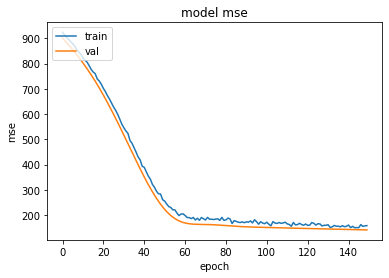

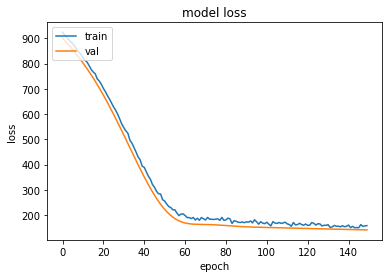

In [56]:
_=plt.figure(facecolor='white')
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])

plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

_=plt.figure(facecolor='white')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [57]:
print(f"{model.evaluate([np.stack(test[:, 0]), np.stack(test[:, 1])], test_y)}")

9/9 [==============================] - 0s 5ms/step - loss: 135.7454 - mse: 135.5310
[135.7454376220703, 135.53102111816406]


In [58]:
#show some predictions from test dataset
start = 0
predictions = 20
for n in range(start, start+predictions):
    print(f"\tPredicted: {model([np.stack(train[n, 0][None, ...]), np.stack(train[n, 1])[None, ...]])}, expected: {test_y[n]}")

	Predicted: [[27.21104]], expected: 0.0
	Predicted: [[37.459538]], expected: 27.2
	Predicted: [[28.264002]], expected: 10.88
	Predicted: [[15.743809]], expected: 10.88
	Predicted: [[10.765977]], expected: 32.64
	Predicted: [[39.08766]], expected: 21.76
	Predicted: [[30.715134]], expected: 27.2
	Predicted: [[29.204018]], expected: 0.0
	Predicted: [[29.733576]], expected: 48.96
	Predicted: [[36.10843]], expected: 32.64
	Predicted: [[4.2648077]], expected: 21.76
	Predicted: [[34.81498]], expected: 10.88
	Predicted: [[40.618187]], expected: 48.96
	Predicted: [[36.28792]], expected: 16.32
	Predicted: [[20.143265]], expected: 32.64
	Predicted: [[23.669178]], expected: 38.08
	Predicted: [[16.798058]], expected: 5.44
	Predicted: [[17.854235]], expected: 16.32
	Predicted: [[27.537678]], expected: 16.32
	Predicted: [[38.778046]], expected: 48.96


In [ ]:
for n, model in enumerate(models):
    model.save(f"models/classification_{modes[n]}.h5")